In [1]:
import os
import pathlib
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from google.colab import files

!pip install -q keras-tuner
!pip install -q torchsummary

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


In [2]:
uploaded = files.upload()
with zipfile.ZipFile("Rock Paper Scissors.zip", "r") as zip_ref:
     zip_ref.extractall("Data")

Saving Rock Paper Scissors.zip to Rock Paper Scissors (1).zip


In [3]:
data_directory = pathlib.Path('/content/Data')
# #reverse folder order
class_names = [item.name for item in data_directory.glob('*')][:3][::-1]
print(class_names)

['paper', 'scissors', 'rock']


In [4]:
paper = '/content/Data/paper'
rock = '/content/Data/rock'
scissors = '/content/Data/scissors'
data_dir = '/content/Data'

In [5]:
print(f'Number of paper images: {len(os.listdir(paper))}')
print(f'Number of rock images: {len(os.listdir(rock))}')
print(f'Number of scissors images: {len(os.listdir(scissors))}')

Number of paper images: 975
Number of rock images: 975
Number of scissors images: 975


In [6]:
import os
import shutil
import random
from pathlib import Path


data_dir = '/content/Data'
output_dir = '/content/Data_split'
categories = ['rock', 'paper', 'scissors']


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


for split in ['train', 'val', 'test']:
    for category in categories:
        Path(f'{output_dir}/{split}/{category}').mkdir(parents=True, exist_ok=True)


for category in categories:
    files = os.listdir(f'{data_dir}/{category}')
    files = [f for f in files if f.endswith('.jpg')]
    random.shuffle(files)

    total = len(files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    split_files = {
        'train': files[:train_end],
        'val': files[train_end:val_end],
        'test': files[val_end:]
    }

    for split, split_list in split_files.items():
        for file in split_list:
            src = f'{data_dir}/{category}/{file}'
            dst = f'{output_dir}/{split}/{category}/{file}'
            shutil.copy(src, dst)

print("Dataset split complete and saved to /content/Data_split")


Dataset split complete and saved to /content/Data_split


In [7]:

image_size_tuple = (224, 224)


transform = transforms.Compose([
    transforms.Resize(image_size_tuple),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataset = ImageFolder(os.path.join(output_dir, 'train'), transform=transform)
val_dataset = ImageFolder(os.path.join(output_dir, 'val'), transform=transform)
test_dataset = ImageFolder(os.path.join(output_dir, 'test'), transform=transform)

In [9]:
batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("Data loaders created successfully!")
print(f'Size of training dataset: {len(train_dataset)}')
print(f'Size of validation dataset: {len(val_dataset)}')
print(f'Number of batches in training loader: {len(train_loader)}')

Data loaders created successfully!
Size of training dataset: 2046
Size of validation dataset: 438
Number of batches in training loader: 64


# **Simple CNN**

In [10]:
# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    """
    Function to handle the training and validation loop.
    """

    model.to(device)


    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    end_time = time.time()
    print(f'Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes')
    return history

Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CustomCNNModel(nn.Module):
    def __init__(self):
        super(CustomCNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            dummy_out = self.features(dummy)
            self.flattened_size = dummy_out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Using device: cuda


In [12]:
def evaluate_on_test_set(model, loader, criterion):
    model.eval()
    model.to(device)
    running_loss, correct_predictions, total_predictions = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    final_loss = running_loss / len(loader.dataset)
    final_acc = correct_predictions / total_predictions
    return final_loss, final_acc

In [13]:
# --- PLOTTING FUNCTION ---
def plot_curves(history, model_name):
    # Plotting Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
print("Training the new Custom CNN Model...")

custom_model = CustomCNNModel()

learning_rate = 0.000001
weight_decay = 0.01
num_epochs =5

optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

custom_model_history = train_and_validate(custom_model, train_loader, val_loader, optimizer, criterion, num_epochs)

print("\nPlotting results for the Custom CNN Model...")

final_val_acc = custom_model_history['val_acc'][-1]
print(f"Final Validation Accuracy for the Custom CNN Model: {final_val_acc:.4f}")

Training the new Custom CNN Model...
Epoch 1/5 | Train Loss: 1.0957 | Train Acc: 0.3573 | Val Loss: 1.0887 | Val Acc: 0.4589
Epoch 2/5 | Train Loss: 1.0856 | Train Acc: 0.4365 | Val Loss: 1.0802 | Val Acc: 0.5183
Epoch 3/5 | Train Loss: 1.0765 | Train Acc: 0.4995 | Val Loss: 1.0713 | Val Acc: 0.6027
Epoch 4/5 | Train Loss: 1.0676 | Train Acc: 0.5391 | Val Loss: 1.0619 | Val Acc: 0.6210
Epoch 5/5 | Train Loss: 1.0609 | Train Acc: 0.5357 | Val Loss: 1.0526 | Val Acc: 0.5913
Finished Training. Total time: 0.74 minutes

Plotting results for the Custom CNN Model...
Final Validation Accuracy for the Custom CNN Model: 0.5913


Training the new Custom CNN Model...
Epoch 1/5 | Train Loss: 1.0712 | Train Acc: 0.4306 | Val Loss: 1.0308 | Val Acc: 0.5799
Epoch 2/5 | Train Loss: 1.0011 | Train Acc: 0.6036 | Val Loss: 0.9466 | Val Acc: 0.7854
Epoch 3/5 | Train Loss: 0.9147 | Train Acc: 0.7077 | Val Loss: 0.8560 | Val Acc: 0.7831
Epoch 4/5 | Train Loss: 0.8255 | Train Acc: 0.7625 | Val Loss: 0.7612 | Val Acc: 0.8425
Epoch 5/5 | Train Loss: 0.7416 | Train Acc: 0.8162 | Val Loss: 0.6695 | Val Acc: 0.8973
Finished Training. Total time: 0.72 minutes

Plotting results for the Custom CNN Model...


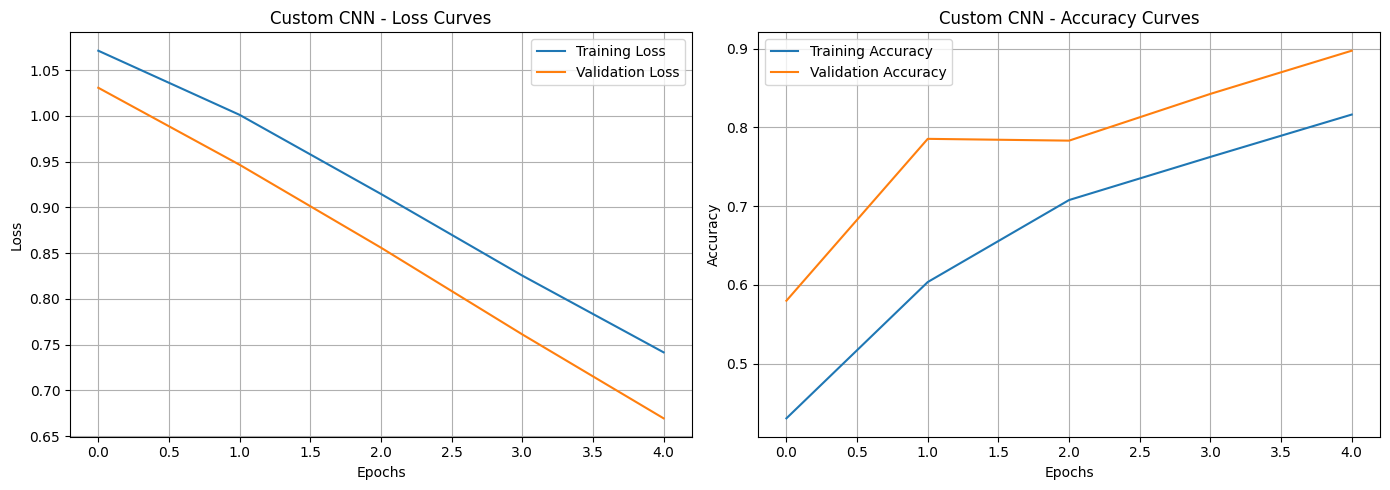

Final Validation Accuracy for the Custom CNN Model: 0.8973


In [15]:
print("Training the new Custom CNN Model...")

custom_model = CustomCNNModel()

learning_rate = 0.00001
weight_decay = 0.001
num_epochs =5

optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

custom_model_history = train_and_validate(custom_model, train_loader, val_loader, optimizer, criterion, num_epochs)

print("\nPlotting results for the Custom CNN Model...")
plot_curves(custom_model_history, "Custom CNN")

final_val_acc = custom_model_history['val_acc'][-1]
print(f"Final Validation Accuracy for the Custom CNN Model: {final_val_acc:.4f}")

In [16]:
print("Training the new Custom CNN Model...")

custom_model = CustomCNNModel()

learning_rate = 0.000001
weight_decay = 0.003
num_epochs =5

optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

custom_model_history = train_and_validate(custom_model, train_loader, val_loader, optimizer, criterion, num_epochs)

print("\nPlotting results for the Custom CNN Model...")

final_val_acc = custom_model_history['val_acc'][-1]
print(f"Final Validation Accuracy for the Custom CNN Model: {final_val_acc:.4f}")

Training the new Custom CNN Model...
Epoch 1/5 | Train Loss: 1.0956 | Train Acc: 0.4071 | Val Loss: 1.0934 | Val Acc: 0.6461
Epoch 2/5 | Train Loss: 1.0917 | Train Acc: 0.4418 | Val Loss: 1.0892 | Val Acc: 0.5434
Epoch 3/5 | Train Loss: 1.0877 | Train Acc: 0.4936 | Val Loss: 1.0849 | Val Acc: 0.5548
Epoch 4/5 | Train Loss: 1.0830 | Train Acc: 0.5117 | Val Loss: 1.0803 | Val Acc: 0.6347
Epoch 5/5 | Train Loss: 1.0776 | Train Acc: 0.6119 | Val Loss: 1.0754 | Val Acc: 0.6872
Finished Training. Total time: 0.72 minutes

Plotting results for the Custom CNN Model...
Final Validation Accuracy for the Custom CNN Model: 0.6872


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time


print("--- Training Final Simple CNN Model ---")

learning_rate = 0.00001
weight_decay = 0.001
num_epochs =5
final_model = CustomCNNModel()

optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

training_history = train_and_validate(final_model, train_loader, val_loader, optimizer, criterion, num_epochs)


print("\n--- Evaluating Final Model on Test Data ---")


test_loss, test_accuracy = evaluate_on_test_set(final_model, test_loader, criterion)

print(f"\n--- Final Test Results ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

--- Training Final Simple CNN Model ---
Epoch 1/5 | Train Loss: 1.0862 | Train Acc: 0.4291 | Val Loss: 1.0678 | Val Acc: 0.4566
Epoch 2/5 | Train Loss: 1.0489 | Train Acc: 0.5450 | Val Loss: 1.0170 | Val Acc: 0.7078
Epoch 3/5 | Train Loss: 0.9940 | Train Acc: 0.6540 | Val Loss: 0.9566 | Val Acc: 0.8014
Epoch 4/5 | Train Loss: 0.9362 | Train Acc: 0.6823 | Val Loss: 0.8856 | Val Acc: 0.7329
Epoch 5/5 | Train Loss: 0.8633 | Train Acc: 0.7537 | Val Loss: 0.8074 | Val Acc: 0.7808
Finished Training. Total time: 0.72 minutes

--- Evaluating Final Model on Test Data ---

--- Final Test Results ---
Test Loss: 0.8098
Test Accuracy: 80.05%


In [18]:
import torch
import numpy as np
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

final_model.eval()
final_model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes

print("--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

--- Classification Report ---
              precision    recall  f1-score   support

       paper       0.82      0.82      0.82       147
        rock       0.96      0.65      0.78       147
    scissors       0.70      0.93      0.80       147

    accuracy                           0.80       441
   macro avg       0.83      0.80      0.80       441
weighted avg       0.83      0.80      0.80       441



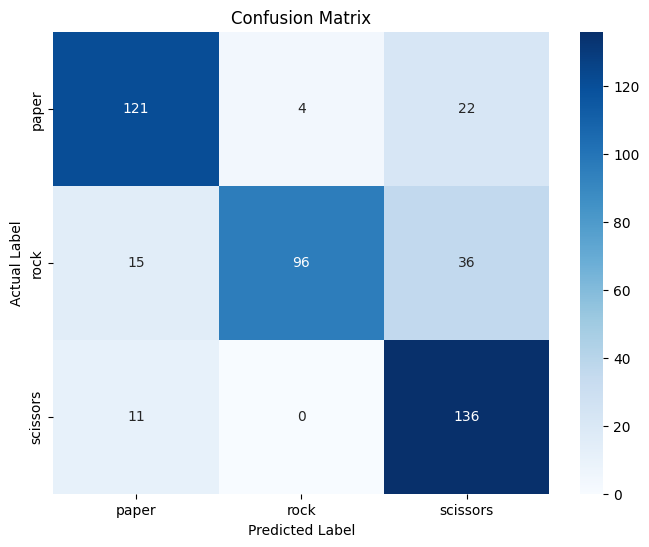

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# **VGG 16**

Using device: cuda

--------------------------------------------------
Training VGG16 with: Learning Rate=1e-06, Weight Decay=0.031
--------------------------------------------------


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.7MB/s]


Epoch 1/5 | Train Loss: 1.1306 | Train Acc: 0.3485 | Val Loss: 1.0242 | Val Acc: 0.6689
Epoch 2/5 | Train Loss: 1.0024 | Train Acc: 0.5200 | Val Loss: 0.9175 | Val Acc: 0.8881
Epoch 3/5 | Train Loss: 0.9136 | Train Acc: 0.6461 | Val Loss: 0.8200 | Val Acc: 0.9498
Epoch 4/5 | Train Loss: 0.8271 | Train Acc: 0.7561 | Val Loss: 0.7269 | Val Acc: 0.9658
Epoch 5/5 | Train Loss: 0.7287 | Train Acc: 0.8343 | Val Loss: 0.6384 | Val Acc: 0.9726
Finished Training. Total time: 1.91 minutes

--------------------------------------------------
Training VGG16 with: Learning Rate=1e-06, Weight Decay=0.12
--------------------------------------------------
Epoch 1/5 | Train Loss: 1.0806 | Train Acc: 0.4145 | Val Loss: 0.9736 | Val Acc: 0.7603
Epoch 2/5 | Train Loss: 0.9723 | Train Acc: 0.5543 | Val Loss: 0.8922 | Val Acc: 0.8790
Epoch 3/5 | Train Loss: 0.9099 | Train Acc: 0.6457 | Val Loss: 0.8182 | Val Acc: 0.9224
Epoch 4/5 | Train Loss: 0.8387 | Train Acc: 0.7160 | Val Loss: 0.7497 | Val Acc: 0.9315
E

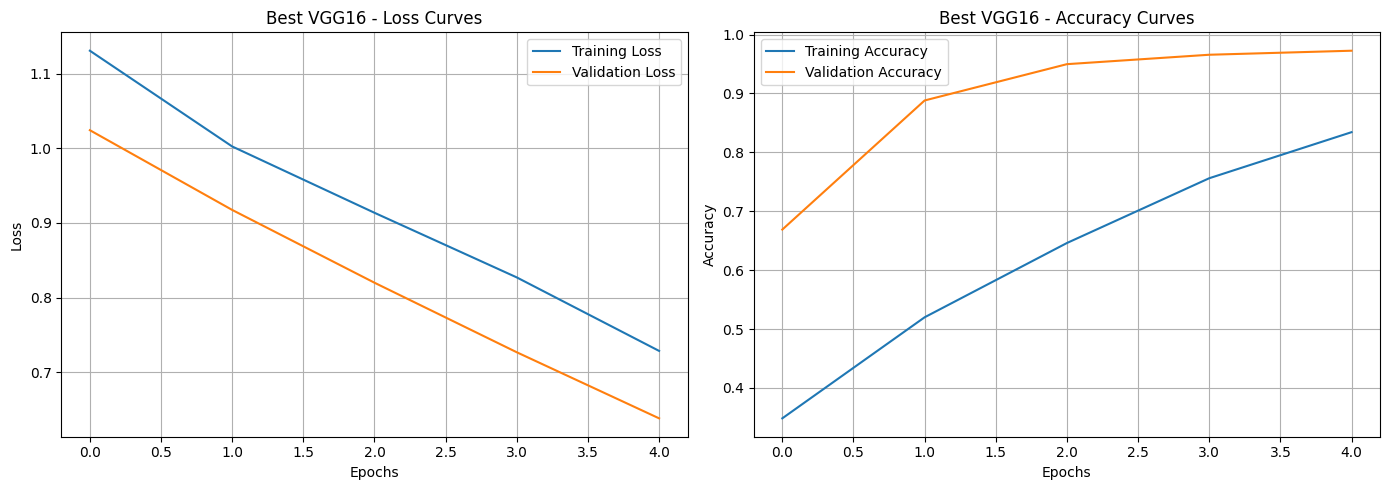

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import VGG16_Weights
import matplotlib.pyplot as plt
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(epochs):

        model.train()
        running_loss, correct_predictions, total_predictions = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)


        model.eval()
        val_running_loss, val_correct_predictions, val_total_predictions = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    end_time = time.time()
    print(f'Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes')
    return history

def plot_curves(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_vgg16_model():
    vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    #Freeze the parameters of the feature extractor
    for param in vgg16.features.parameters():
        param.requires_grad = False

    num_features = vgg16.classifier[-1].in_features
    vgg16.classifier[-1] = nn.Linear(num_features, 3)

    return vgg16


hyperparameters = [
    {'lr': 0.000001, 'wd': 0.031},
    {'lr': 0.000001, 'wd': 0.120},
    {'lr': 0.0000001, 'wd': 0.0350}
]

num_epochs = 5
all_histories = []
best_val_acc = 0.0
best_history = None
best_hyperparams = None


for params in hyperparameters:
    print(f"""
--------------------------------------------------
Training VGG16 with: Learning Rate={params['lr']}, Weight Decay={params['wd']}
--------------------------------------------------""")

    vgg16_model = get_vgg16_model()

    optimizer = optim.Adam(vgg16_model.classifier.parameters(), lr=params['lr'], weight_decay=params['wd'])
    criterion = nn.CrossEntropyLoss()

    history = train_and_validate(vgg16_model, train_loader, val_loader, optimizer, criterion, num_epochs)
    all_histories.append(history)

    final_val_acc = history['val_acc'][-1]
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_history = history
        best_hyperparams = params

print(f"""
==================================================
Best performing VGG16 model had:
- Learning Rate: {best_hyperparams['lr']}
- Weight Decay: {best_hyperparams['wd']}
- Final Validation Accuracy: {best_val_acc:.4f}
==================================================
""")

print("Plotting learning curves for the best VGG16 model...")
plot_curves(best_history, "Best VGG16")

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import VGG16_Weights
import matplotlib.pyplot as plt
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_acc:.4f}')

    print('Finished Training.')
    return model

def evaluate_on_test_set(model, loader, criterion):
    model.eval()
    model.to(device)
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_loss = test_loss / len(loader)
    final_acc = correct / total
    return final_loss, final_acc

def get_vgg16_model():
    vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg16.features.parameters():
        param.requires_grad = False
    num_features = vgg16.classifier[-1].in_features
    vgg16.classifier[-1] = nn.Linear(num_features, 3)
    return vgg16


best_vgg16_params = {
      'lr': 0.000001,
      'wd': 0.120,
      'epochs': 5
}



print("--- Training Final VGG16 Model ---")
final_vgg16_model = get_vgg16_model()
optimizer = optim.Adam(final_vgg16_model.classifier.parameters(), lr=best_vgg16_params['lr'], weight_decay=best_vgg16_params['wd'])
criterion = nn.CrossEntropyLoss()

trained_vgg16_model = train_and_validate(final_vgg16_model, train_loader, val_loader, optimizer, criterion, best_vgg16_params['epochs'])

print("\n--- Evaluating VGG16 Model on Test Data ---")
vgg16_test_loss, vgg16_test_accuracy = evaluate_on_test_set(trained_vgg16_model, test_loader, criterion)

print(f"\n--- Final VGG16 Test Results ---")
print(f"Test Loss: {vgg16_test_loss:.4f}")
print(f"Test Accuracy: {vgg16_test_accuracy * 100:.2f}%")

Using device: cuda
--- Training Final VGG16 Model ---
Epoch 1/5, Validation Accuracy: 0.5639
Epoch 2/5, Validation Accuracy: 0.7945
Epoch 3/5, Validation Accuracy: 0.8995
Epoch 4/5, Validation Accuracy: 0.9361
Epoch 5/5, Validation Accuracy: 0.9452
Finished Training.

--- Evaluating VGG16 Model on Test Data ---

--- Final VGG16 Test Results ---
Test Loss: 0.7218
Test Accuracy: 94.56%


In [22]:
import torch
import numpy as np
from sklearn.metrics import classification_report

vgg_all_preds = []
vgg_all_labels = []

final_vgg16_model.eval()
final_vgg16_model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = final_vgg16_model(inputs)
        _, predicted = torch.max(outputs, 1)

        vgg_all_preds.extend(predicted.cpu().numpy())
        vgg_all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes

print("--- VGG16 Classification Report ---")
print(classification_report(vgg_all_labels, vgg_all_preds, target_names=class_names))

--- VGG16 Classification Report ---
              precision    recall  f1-score   support

       paper       0.99      0.91      0.95       147
        rock       0.90      0.97      0.93       147
    scissors       0.95      0.96      0.95       147

    accuracy                           0.95       441
   macro avg       0.95      0.95      0.95       441
weighted avg       0.95      0.95      0.95       441



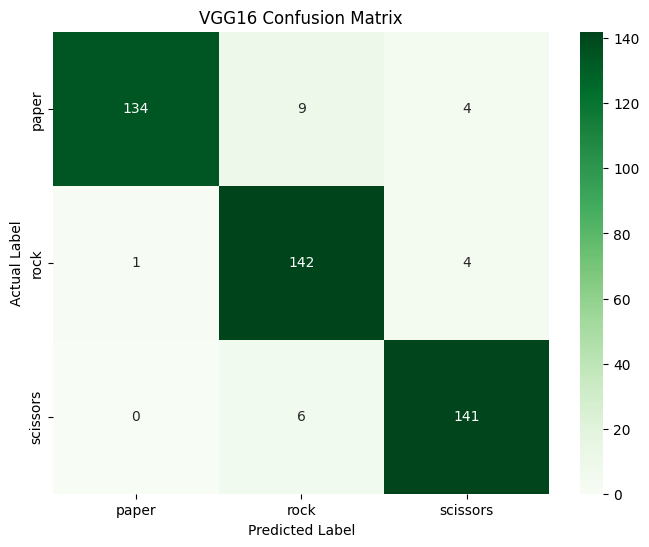

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

vgg_cm = confusion_matrix(vgg_all_labels, vgg_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)

plt.title('VGG16 Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

**RESNET**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):

    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(epochs):

        model.train()
        running_loss, correct_predictions, total_predictions = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)


        model.eval()
        val_running_loss, val_correct_predictions, val_total_predictions = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    end_time = time.time()
    print(f'Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes')
    return history

def plot_curves(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def get_resnet50_model():
    resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    #Freeze all the parameters in the model
    for param in resnet50.parameters():
        param.requires_grad = False

    num_ftrs = resnet50.fc.in_features

    resnet50.fc = nn.Linear(num_ftrs, 3)

    return resnet50

Using device: cuda



--------------------------------------------------
Training ResNet50 with: Learning Rate=1e-05, Weight Decay=0.02
--------------------------------------------------


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch 1/5 | Train Loss: 1.1185 | Train Acc: 0.3280 | Val Loss: 1.0883 | Val Acc: 0.4041
Epoch 2/5 | Train Loss: 1.0775 | Train Acc: 0.4096 | Val Loss: 1.0617 | Val Acc: 0.4543
Epoch 3/5 | Train Loss: 1.0506 | Train Acc: 0.5029 | Val Loss: 1.0334 | Val Acc: 0.5320
Epoch 4/5 | Train Loss: 1.0259 | Train Acc: 0.5743 | Val Loss: 1.0061 | Val Acc: 0.6096
Epoch 5/5 | Train Loss: 0.9978 | Train Acc: 0.6457 | Val Loss: 0.9814 | Val Acc: 0.6826
Finished Training. Total time: 1.18 minutes

--------------------------------------------------
Training ResNet50 with: Learning Rate=1e-05, Weight Decay=0.045
--------------------------------------------------
Epoch 1/5 | Train Loss: 1.0989 | Train Acc: 0.3729 | Val Loss: 1.0723 | Val Acc: 0.4498
Epoch 2/5 | Train Loss: 1.0671 | Train Acc: 0.4409 | Val Loss: 1.0411 | Val Acc: 0.5274
Epoch 3/5 | Train Loss: 1.0406 | Train Acc: 0.5279 | Val Loss: 1.0116 | Val Acc: 0.6142
Epoch 4/5 | Train Loss: 1.0164 | Train Acc: 0.6026 | Val Loss: 0.9845 | Val Acc: 0.68

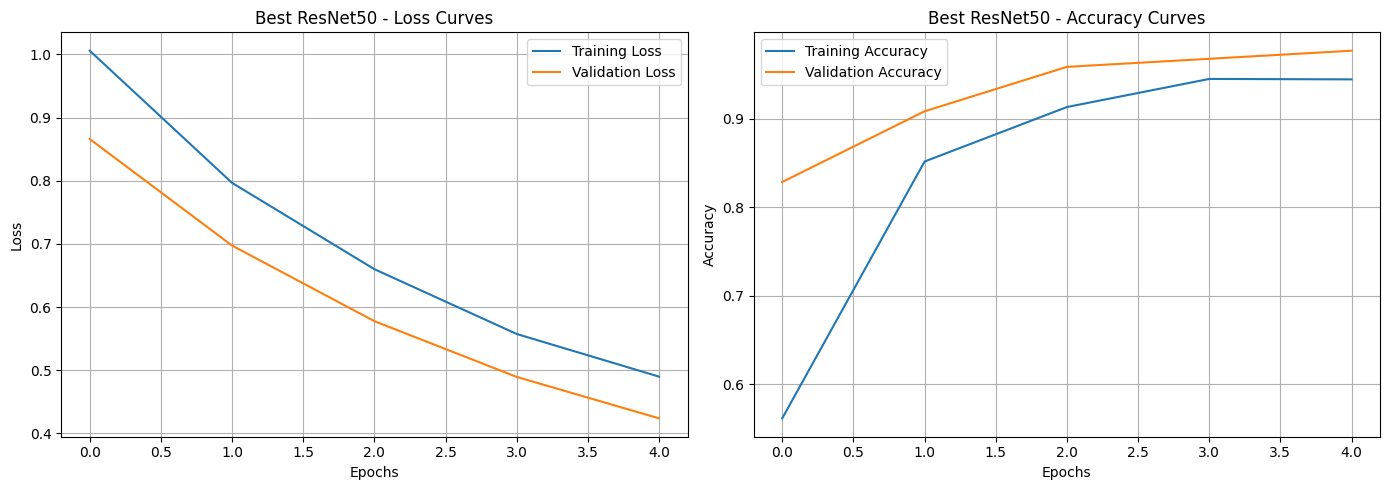

In [25]:
hyperparameters = [
    {'lr': 0.00001, 'wd': 0.02},
    {'lr': 0.00001, 'wd': 0.045},
    {'lr': 0.0001, 'wd': 0.05}
]

num_epochs = 5
all_histories = []
best_val_acc = 0.0
best_history = None
best_hyperparams = None


for params in hyperparameters:
    print(f"""
--------------------------------------------------
Training ResNet50 with: Learning Rate={params['lr']}, Weight Decay={params['wd']}
--------------------------------------------------""")


    resnet_model = get_resnet50_model()


    optimizer = optim.Adam(resnet_model.parameters(), lr=params['lr'], weight_decay=params['wd'])
    criterion = nn.CrossEntropyLoss()

    history = train_and_validate(resnet_model, train_loader, val_loader, optimizer, criterion, num_epochs)
    all_histories.append(history)

    final_val_acc = history['val_acc'][-1]
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_history = history
        best_hyperparams = params

print(f"""
==================================================
Best performing ResNet50 model had:
- Learning Rate: {best_hyperparams['lr']}
- Weight Decay: {best_hyperparams['wd']}
- Final Validation Accuracy: {best_val_acc:.4f}
==================================================
""")

print("Plotting learning curves for the best ResNet50 model...")
plot_curves(best_history, "Best ResNet50")

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {val_acc:.4f}')

    print('Finished Training.')
    return model

def evaluate_on_test_set(model, loader, criterion):
    model.eval()
    model.to(device)
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_loss = test_loss / len(loader)
    final_acc = correct / total
    return final_loss, final_acc

def get_resnet50_model():
    resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    for param in resnet50.parameters():
        param.requires_grad = False
    num_ftrs = resnet50.fc.in_features
    resnet50.fc = nn.Linear(num_ftrs, 3)
    return resnet50



Using device: cuda


In [27]:
best_resnet_params = {
   'lr': 0.0001,
    'wd': 0.05,
    'epochs': 5
}

print("--- Training Final ResNet50 Model ---")
final_resnet_model = get_resnet50_model()
optimizer = optim.Adam(final_resnet_model.parameters(), lr=best_resnet_params['lr'], weight_decay=best_resnet_params['wd'])
criterion = nn.CrossEntropyLoss()

trained_resnet_model = train_and_validate(final_resnet_model, train_loader, val_loader, optimizer, criterion, best_resnet_params['epochs'])

print("\n--- Evaluating ResNet50 Model on Test Data ---")
resnet_test_loss, resnet_test_accuracy = evaluate_on_test_set(trained_resnet_model, test_loader, criterion)

print(f"\n--- Final ResNet50 Test Results ---")
print(f"Test Loss: {resnet_test_loss:.4f}")
print(f"Test Accuracy: {resnet_test_accuracy * 100:.2f}%")

--- Training Final ResNet50 Model ---
Epoch 1/5, Validation Accuracy: 0.8219
Epoch 2/5, Validation Accuracy: 0.9429
Epoch 3/5, Validation Accuracy: 0.9521
Epoch 4/5, Validation Accuracy: 0.9658
Epoch 5/5, Validation Accuracy: 0.9749
Finished Training.

--- Evaluating ResNet50 Model on Test Data ---

--- Final ResNet50 Test Results ---
Test Loss: 0.4331
Test Accuracy: 96.37%


In [28]:
import torch
import numpy as np
from sklearn.metrics import classification_report

resnet_all_preds = []
resnet_all_labels = []

final_resnet_model.eval()
final_resnet_model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = final_resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        resnet_all_preds.extend(predicted.cpu().numpy())
        resnet_all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes

print("--- ResNet50 Classification Report ---")
print(classification_report(resnet_all_labels, resnet_all_preds, target_names=class_names))

--- ResNet50 Classification Report ---
              precision    recall  f1-score   support

       paper       0.98      0.95      0.97       147
        rock       0.98      0.97      0.97       147
    scissors       0.93      0.97      0.95       147

    accuracy                           0.96       441
   macro avg       0.96      0.96      0.96       441
weighted avg       0.96      0.96      0.96       441



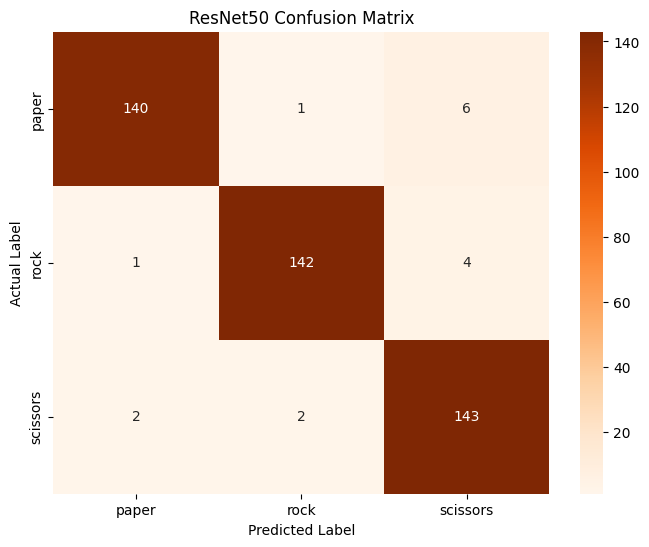

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

resnet_cm = confusion_matrix(resnet_all_labels, resnet_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)

plt.title('ResNet50 Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

**GoogLeNet**

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate_googlenet(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct_predictions, total_predictions = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss0 = criterion(outputs.logits, labels)
            loss1 = criterion(outputs.aux_logits1, labels)
            loss2 = criterion(outputs.aux_logits2, labels)
            loss = loss0 + 0.3 * loss1 + 0.3 * loss2

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.logits, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_running_loss, val_correct_predictions, val_total_predictions = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct_predictions / val_total_predictions
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    end_time = time.time()
    print(f'Finished Training. Total time: {(end_time - start_time)/60:.2f} minutes')
    return history

def plot_curves(history, model_name):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_googlenet_model():

    googlenet = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)

    for param in googlenet.parameters():
        param.requires_grad = False

    num_ftrs = googlenet.fc.in_features
    googlenet.fc = nn.Linear(num_ftrs, 3)

    num_ftrs_aux1 = googlenet.aux1.fc2.in_features
    googlenet.aux1.fc2 = nn.Linear(num_ftrs_aux1, 3)

    num_ftrs_aux2 = googlenet.aux2.fc2.in_features
    googlenet.aux2.fc2 = nn.Linear(num_ftrs_aux2, 3)

    return googlenet

Using device: cuda



--------------------------------------------------
Training GoogLeNet with: Learning Rate=1e-06, Weight Decay=0.0002
--------------------------------------------------


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 197MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/5 | Train Loss: 1.8729 | Train Acc: 0.2805 | Val Loss: 1.1336 | Val Acc: 0.2694
Epoch 2/5 | Train Loss: 1.8664 | Train Acc: 0.2820 | Val Loss: 1.1363 | Val Acc: 0.2694
Epoch 3/5 | Train Loss: 1.8669 | Train Acc: 0.2849 | Val Loss: 1.1333 | Val Acc: 0.2922
Epoch 4/5 | Train Loss: 1.8601 | Train Acc: 0.2952 | Val Loss: 1.1303 | Val Acc: 0.2922
Epoch 5/5 | Train Loss: 1.8640 | Train Acc: 0.2688 | Val Loss: 1.1284 | Val Acc: 0.2854
Finished Training. Total time: 0.83 minutes

--------------------------------------------------
Training GoogLeNet with: Learning Rate=0.0001, Weight Decay=0.0655
--------------------------------------------------
Epoch 1/5 | Train Loss: 1.7185 | Train Acc: 0.4677 | Val Loss: 0.9602 | Val Acc: 0.7397
Epoch 2/5 | Train Loss: 1.5061 | Train Acc: 0.7317 | Val Loss: 0.8348 | Val Acc: 0.8881
Epoch 3/5 | Train Loss: 1.3352 | Train Acc: 0.8480 | Val Loss: 0.7364 | Val Acc: 0.9269
Epoch 4/5 | Train Loss: 1.2011 | Train Acc: 0.8832 | Val Loss: 0.6575 | Val Acc: 0

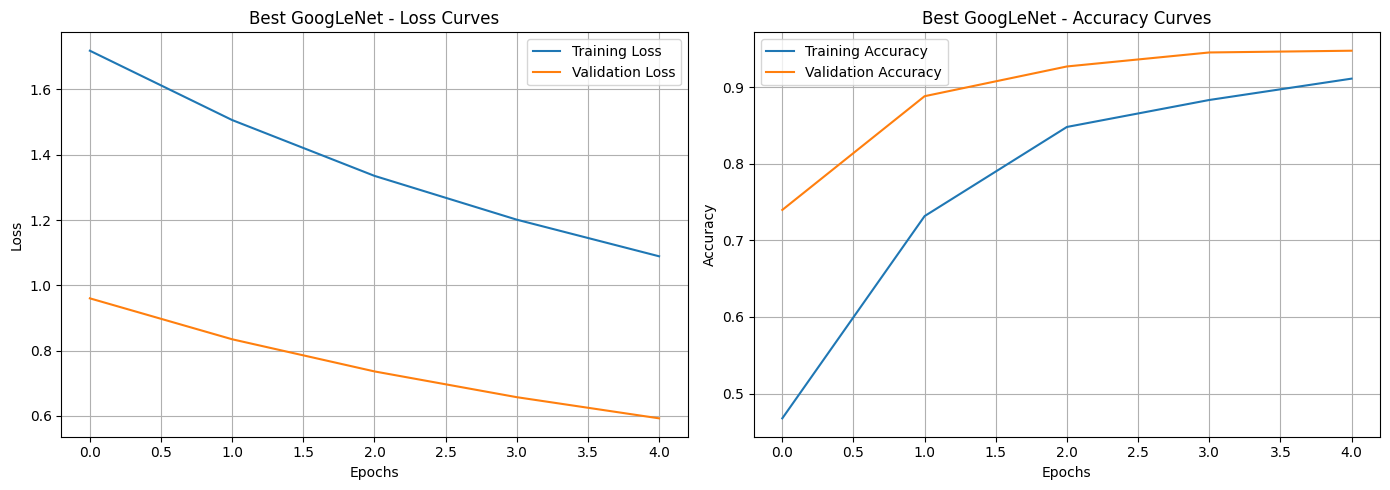

In [31]:
hyperparameters = [
    {'lr': 0.000001, 'wd': 0.0002},
    {'lr': 0.0001, 'wd': 0.0655},
    {'lr': 0.00001, 'wd': 0.03}
]

num_epochs = 5
best_val_acc = 0.0
best_history = None
best_hyperparams = None

for params in hyperparameters:
    print(f"""
--------------------------------------------------
Training GoogLeNet with: Learning Rate={params['lr']}, Weight Decay={params['wd']}
--------------------------------------------------""")

    googlenet_model = get_googlenet_model()
    optimizer = optim.Adam(googlenet_model.parameters(), lr=params['lr'], weight_decay=params['wd'])
    criterion = nn.CrossEntropyLoss()

    history = train_and_validate_googlenet(googlenet_model, train_loader, val_loader, optimizer, criterion, num_epochs)

    final_val_acc = history['val_acc'][-1]
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_history = history
        best_hyperparams = params

print(f"""
==================================================
Best performing GoogLeNet model had:
- Learning Rate: {best_hyperparams['lr']}
- Weight Decay: {best_hyperparams['wd']}
- Final Validation Accuracy: {best_val_acc:.4f}
==================================================
""")

print("Plotting learning curves for the best GoogLeNet model...")
plot_curves(best_history, "Best GoogLeNet")

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_and_validate_googlenet(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss0 = criterion(outputs.logits, labels)
            loss1 = criterion(outputs.aux_logits1, labels)
            loss2 = criterion(outputs.aux_logits2, labels)
            loss = loss0 + 0.3 * loss1 + 0.3 * loss2
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.4f}')

    print('Finished Training.')
    return model

def evaluate_on_test_set(model, loader, criterion):
    model.eval()
    model.to(device)
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_loss = test_loss / len(loader)
    final_acc = correct / total
    return final_loss, final_acc

def get_googlenet_model():
    googlenet = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)
    for param in googlenet.parameters():
        param.requires_grad = False

    googlenet.fc = nn.Linear(googlenet.fc.in_features, 3)
    googlenet.aux1.fc2 = nn.Linear(googlenet.aux1.fc2.in_features, 3)
    googlenet.aux2.fc2 = nn.Linear(googlenet.aux2.fc2.in_features, 3)

    return googlenet

Using device: cuda


In [33]:
best_googlenet_params = {
    'lr': 0.0001,
    'wd': 0.0655,
    'epochs': 5
}

print("--- Training Final GoogLeNet Model ---")
final_googlenet_model = get_googlenet_model()
optimizer = optim.Adam(final_googlenet_model.parameters(), lr=best_googlenet_params['lr'], weight_decay=best_googlenet_params['wd'])
criterion = nn.CrossEntropyLoss()

trained_googlenet_model = train_and_validate_googlenet(final_googlenet_model, train_loader, val_loader, optimizer, criterion, best_googlenet_params['epochs'])

print("\n--- Evaluating GoogLeNet Model on Test Data ---")
googlenet_test_loss, googlenet_test_accuracy = evaluate_on_test_set(trained_googlenet_model, test_loader, criterion)

print(f"\n--- Final GoogLeNet Test Results ---")
print(f"Test Loss: {googlenet_test_loss:.4f}")
print(f"Test Accuracy: {googlenet_test_accuracy * 100:.2f}%")

--- Training Final GoogLeNet Model ---
Epoch 1/5, Validation Accuracy: 0.7260
Epoch 2/5, Validation Accuracy: 0.8973
Epoch 3/5, Validation Accuracy: 0.9201
Epoch 4/5, Validation Accuracy: 0.9452
Epoch 5/5, Validation Accuracy: 0.9543
Finished Training.

--- Evaluating GoogLeNet Model on Test Data ---

--- Final GoogLeNet Test Results ---
Test Loss: 0.6182
Test Accuracy: 92.74%


In [34]:
import numpy as np
from sklearn.metrics import classification_report

googlenet_all_preds = []
googlenet_all_labels = []

trained_googlenet_model.eval()
trained_googlenet_model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = trained_googlenet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        googlenet_all_preds.extend(predicted.cpu().numpy())
        googlenet_all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes

print("--- GoogLeNet Classification Report ---")
print(classification_report(googlenet_all_labels, googlenet_all_preds, target_names=class_names))

--- GoogLeNet Classification Report ---
              precision    recall  f1-score   support

       paper       0.96      0.92      0.94       147
        rock       0.94      0.90      0.92       147
    scissors       0.88      0.96      0.92       147

    accuracy                           0.93       441
   macro avg       0.93      0.93      0.93       441
weighted avg       0.93      0.93      0.93       441



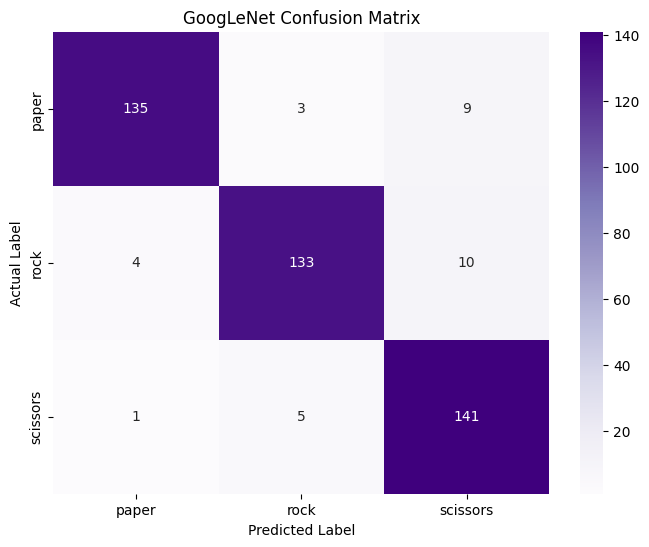

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

googlenet_cm = confusion_matrix(googlenet_all_labels, googlenet_all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(googlenet_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)

plt.title('GoogLeNet Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

**Number Of Parameters**

In [36]:
from torchsummary import summary
print("--- Summary for CustomCNNModel ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CustomCNNModel().to(device)
summary(cnn_model, input_size=(3, 224, 224))


PATH = "custom_cnn_model.pth"
torch.save(cnn_model.state_dict(), PATH)
print(f"\nCustomCNNModel state dictionary saved to {PATH}")

--- Summary for CustomCNNModel ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 223, 223]             130
              ReLU-2         [-1, 10, 223, 223]               0
         MaxPool2d-3         [-1, 10, 111, 111]               0
            Conv2d-4         [-1, 32, 110, 110]           1,312
              ReLU-5         [-1, 32, 110, 110]               0
         MaxPool2d-6           [-1, 32, 55, 55]               0
            Conv2d-7           [-1, 64, 54, 54]           8,256
              ReLU-8           [-1, 64, 54, 54]               0
         MaxPool2d-9           [-1, 64, 27, 27]               0
          Flatten-10                [-1, 46656]               0
           Linear-11                  [-1, 128]       5,972,096
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
    

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights
from torchsummary import summary

def get_vgg16_model():
    vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg16.features.parameters():
        param.requires_grad = False
    num_features = vgg16.classifier[-1].in_features
    vgg16.classifier[-1] = nn.Linear(num_features, 3)
    return vgg16

print("--- Summary for VGG16 ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model = get_vgg16_model().to(device)
summary(vgg16_model, input_size=(3, 224, 224))


PATH = "vgg16_model.pth"
torch.save(vgg16_model.state_dict(), PATH)
print(f"\nVGG16 model state dictionary saved to {PATH}")

--- Summary for VGG16 ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchsummary import summary

def get_resnet50_model():
    resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    for param in resnet50.parameters():
        param.requires_grad = False
    num_ftrs = resnet50.fc.in_features
    resnet50.fc = nn.Linear(num_ftrs, 3)
    return resnet50

print("--- Summary for ResNet50 ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = get_resnet50_model().to(device)
summary(resnet_model, input_size=(3, 224, 224))


PATH = "resnet50_model.pth"
torch.save(resnet_model.state_dict(), PATH)
print(f"\nResNet50 model state dictionary saved to {PATH}")

--- Summary for ResNet50 ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      Batc

In [39]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights
from torchsummary import summary

def get_googlenet_model():
    googlenet = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)

    for param in googlenet.parameters():
        param.requires_grad = False

    num_ftrs = googlenet.fc.in_features
    googlenet.fc = nn.Linear(num_ftrs, 3)

    googlenet.aux1.fc2 = nn.Linear(googlenet.aux1.fc2.in_features, 3)
    googlenet.aux2.fc2 = nn.Linear(googlenet.aux2.fc2.in_features, 3)

    return googlenet

print("--- Summary for GoogLeNet ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet_model = get_googlenet_model().to(device)

summary(googlenet_model, input_size=(3, 224, 224))


PATH = "googlenet_model.pth"
torch.save(googlenet_model.state_dict(), PATH)
print(f"\nGoogLeNet model state dictionary saved to {PATH}")

--- Summary for GoogLeNet ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [60]:
import torch


CHECKPOINT_PATH = "/content/googlenet_model.pth"


try:
    # Load the saved object from the file
    loaded_object = torch.load(CHECKPOINT_PATH, map_location='cpu')
    print(f"Successfully loaded file from: {CHECKPOINT_PATH}\n")

    if isinstance(loaded_object, dict) and 'model_state_dict' in loaded_object:
        state_dictionary = loaded_object['model_state_dict']
    else:
        state_dictionary = loaded_object

    # --- 3. Inspect the Model's Parameters ---
    print("--- Layers and Parameter Shapes in the Saved File ---")

    # Print the name and shape of every parameter tensor
    for i, (param_name, param_tensor) in enumerate(state_dictionary.items()):
        if i >= 25:
            break
        print(f"{param_name: <30}\t{param_tensor.size()}")


except FileNotFoundError:
    print(f"Error: The file '{CHECKPOINT_PATH}' was not found.")
    print("Please make sure you have run the code to save the model first.")

Successfully loaded file from: /content/googlenet_model.pth

--- Layers and Parameter Shapes in the Saved File ---
conv1.conv.weight             	torch.Size([64, 3, 7, 7])
conv1.bn.weight               	torch.Size([64])
conv1.bn.bias                 	torch.Size([64])
conv1.bn.running_mean         	torch.Size([64])
conv1.bn.running_var          	torch.Size([64])
conv1.bn.num_batches_tracked  	torch.Size([])
conv2.conv.weight             	torch.Size([64, 64, 1, 1])
conv2.bn.weight               	torch.Size([64])
conv2.bn.bias                 	torch.Size([64])
conv2.bn.running_mean         	torch.Size([64])
conv2.bn.running_var          	torch.Size([64])
conv2.bn.num_batches_tracked  	torch.Size([])
conv3.conv.weight             	torch.Size([192, 64, 3, 3])
conv3.bn.weight               	torch.Size([192])
conv3.bn.bias                 	torch.Size([192])
conv3.bn.running_mean         	torch.Size([192])
conv3.bn.running_var          	torch.Size([192])
conv3.bn.num_batches_tracked  	torch.Si

In [40]:
# from PIL import Image
# import torchvision.transforms as transforms


# def predict_image(model_path, model_architecture, image_path, class_names):


#     if model_architecture == 'resnet':
#         model = get_resnet50_model()
#     elif model_architecture == 'vgg':
#         model = get_vgg16_model()

#     else:
#         print("Invalid model architecture specified.")
#         return


#     model.load_state_dict(torch.load(model_path))
#     model.eval()
#     model.to(device)


#     image_transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     image = Image.open(image_path).convert('RGB')
#     image_tensor = image_transform(image).unsqueeze(0)
#     image_tensor = image_tensor.to(device)

#     with torch.no_grad():
#         outputs = model(image_tensor)
#         _, predicted_idx = torch.max(outputs, 1)

#     predicted_class = class_names[predicted_idx.item()]

#     print(f"The model predicts that the image is: {predicted_class}")

In [41]:
from PIL import Image
import torchvision.transforms as transforms
def predict_image(model_path, model_architecture, image_path, class_names):

    if model_architecture == 'cnn':
        model = CustomCNNModel()
    elif model_architecture == 'vgg':
        model = get_vgg16_model()
    elif model_architecture == 'resnet':
        model = get_resnet50_model()
    elif model_architecture == 'googlenet':
        model = get_googlenet_model()
    else:
        print("Invalid model architecture specified. Choose from 'cnn', 'vgg', 'resnet', or 'googlenet'.")
        return

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)

    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image not found at path '{image_path}'")
        return

    image_tensor = image_transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)

    predicted_class = class_names[predicted_idx.item()]

    print(f"Model: {model_architecture.upper()}")
    print(f"Image: {image_path}")
    print(f"Prediction: {predicted_class}")
    print("-" * 30)

In [42]:
class_names = ['paper', 'rock', 'scissors']


predict_image('custom_cnn_model.pth', 'cnn', '/content/One.jpeg', class_names)
predict_image('vgg16_model.pth', 'vgg', '/content/One.jpeg', class_names)
predict_image('resnet50_model.pth', 'resnet', '/content/One.jpeg', class_names)
predict_image('googlenet_model.pth', 'googlenet', '/content/One.jpeg', class_names)

Error: Image not found at path '/content/One.jpeg'
Error: Image not found at path '/content/One.jpeg'
Error: Image not found at path '/content/One.jpeg'
Error: Image not found at path '/content/One.jpeg'


In [43]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


In [44]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
import mediapipe as mp

def get_vgg16_model():
    model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, 3)
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = "vgg16_model.pth"

model = get_vgg16_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
model.to(device)
print("VGG16 model loaded successfully.")

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
class_names = ['paper', 'rock', 'scissors']
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to Capture and Predict a Single Photo ---
def take_and_predict_photo(quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  nparr = np.frombuffer(binary, np.uint8)
  frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

  # Hand Detection Logic
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = hands.process(frame_rgb)

  prediction_text = "No hand detected"
  if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
          h, w, _ = frame.shape
          x_coords = [landmark.x for landmark in hand_landmarks.landmark]
          y_coords = [landmark.y for landmark in hand_landmarks.landmark]
          x_min, x_max = min(x_coords), max(x_coords)
          y_min, y_max = min(y_coords), max(y_coords)

          box_w = x_max - x_min
          box_h = y_max - y_min
          box_size = max(box_w, box_h) * 1.2

          center_x = (x_min + box_w / 2) * w
          center_y = (y_min + box_h / 2) * h

          x1 = int(center_x - (box_size * w / 2))
          y1 = int(center_y - (box_size * h / 2))
          x2 = int(center_x + (box_size * w / 2))
          y2 = int(center_y + (box_size * h / 2))

          x1, y1 = max(0, x1), max(0, y1)
          x2, y2 = min(w, x2), min(h, y2)

          cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
          hand_roi = frame[y1:y2, x1:x2]

          if hand_roi.size > 0:
              pil_image = Image.fromarray(cv2.cvtColor(hand_roi, cv2.COLOR_BGR2RGB))
              image_tensor = image_transform(pil_image).unsqueeze(0).to(device)

              with torch.no_grad():
                  outputs = model(image_tensor)
                  _, predicted_idx = torch.max(outputs, 1)

              prediction_text = class_names[predicted_idx.item()]

  cv2.putText(frame, f'Prediction: {prediction_text}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
  from google.colab.patches import cv2_imshow
  cv2_imshow(frame)

print("Starting camera... Click 'Capture' to predict.")
take_and_predict_photo()

VGG16 model loaded successfully.
Starting camera... Click 'Capture' to predict.


<IPython.core.display.Javascript object>

MessageError: NotAllowedError: Permission denied